In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import re
import os
import PyPDF2
from nltk.corpus import stopwords, gutenberg
from collections import Counter

In [91]:
from sklearn import metrics, ensemble
from itertools import cycle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, SpectralClustering, AffinityPropagation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

In [2]:
# parse the texts in separate kernels
nlp = spacy.load('en')

## Load Data

##### --Load Books

In [3]:
# function for standard text cleaning.
def text_cleaner(text):
    # visual inspection identifies a form of punctuation spaCy does not
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    
    return text

In [4]:
# load m texts from the directory
def load_book(sample):

    content_text = []
    
    for m in sample:
        file = open(m, encoding = "utf8").read()
        file = text_cleaner(file)

        # there are many '***' in all the texts, after spliting them, there will multiple values    
        file = file.split('***')   
        max_ = 0
        for i,v in enumerate(file):
            if len(v) > max_:
                max_ = len(v)
                text = i

        content_text.append(file[text])
        
    return pd.DataFrame({'text': content_text})

In [5]:
# locate 30 smallest texts files to save time when running the dataset
def find_book(sample):
    leng = []
    for i in range(len(sample)):
        leng.append(len(sample['text'][i]))
            
    # create column for length of text and find 30 shortest length texts
    sample['text_len'] = leng
    sample = sample.sort_values(['text_len'], ascending = True).head(30)
    sample.reset_index(drop = ['index'], inplace = True)
    
    return sample

##### --Load Articles

In [6]:
# create function to read pdf files
def read_pdf(sample):
    # creating a pdf file object
    pdfFileObj = open(sample , 'rb')

    # creating a pdf reader object
    pdfReader = PyPDF2.PdfFileReader(pdfFileObj)

    content = []
    for i in range(pdfReader.numPages):
        # creating a page object
        pageObj = pdfReader.getPage(i)

        # extracting text from page
        text = pageObj.extractText()

        # append each page to an array
        content.append(text)

    # closing the pdf file object
    pdfFileObj.close()
    
    return content

In [7]:
# create a function to clean and process pdf files
def load_pdf(sample):
    
    content_text = []
    leng = []
    
    for n in sample:
        file = read_pdf(n)
      
        # there is a reference section in each articles, want to remove them
        file = str(file).split('References')
        max_ = 0
        for i,v in enumerate(file):
            if len(v) > max_:
                max_ = len(v)
                text = i

        content_text.append(file[text])
        leng.append(len(file[text]))
        
    return pd.DataFrame({'text': content_text, 'text_len': leng})
        

##### -- Call Data

In [8]:
# load 30 fiction books
os.chdir('C:/Users/Mike/AnacondaProjects/Unit 4/Capstone/fiction')
fiction = os.listdir()

# load 30 texts from fiction folder
fict_sample = load_book(fiction)
fict_sample = find_book(fict_sample)

# assign a category 
fict_sample['category'] = pd.Series(['fiction'] * fict_sample.shape[0])

In [9]:
# load 30 non fiction books
os.chdir('C:/Users/Mike/AnacondaProjects/Unit 4/Capstone/non_fiction')
nonfict = os.listdir()

# load 30 texts from non-fiction folder
nonfict_sample = load_book(nonfict)
nonfict_sample = find_book(nonfict_sample)

#assign a category
nonfict_sample['category'] = pd.Series(['non_fiction'] * nonfict_sample.shape[0])

In [10]:
# load 40 articles
os.chdir('C:/Users/Mike/AnacondaProjects/Unit 4/Capstone/articles')
articles = os.listdir()

# load 40 texts from article folder
art_sample = load_pdf(articles)

#assign a category
art_sample['category'] = pd.Series(['article'] * art_sample.shape[0])

## Clean and Process Data

    feature ideas: length of sentence, and number of paragraph

In [11]:
# function to read the text by paragraph in articles
def book_para(text):
    para = []
    
    text = text.split('\n\n')        #indicator of paragraph in books
    for i in range(len(text)):
        if text[i] != '':
            para.append(text[i])
            
    return para

In [12]:
# function to read the text by paragraph in articles
def art_para(text):
    para = []
    
    indi_1 = text.split('.\\n')       # indicators of paragraph in articles
    indi_2 = text.split('\\n')        # if first indicator is wrong, use the second one
    
    if len(indi_1) == 1:
        text = indi_2
    else:
        text = indi_1
    
    for i in text:
        if i != '':
            para.append(i)
            
    return para
    

In [13]:
# Fictions
# find fiction paragraph and length of paragraph
paragraph = []
para_len = []

# divide text into arrays of paragraph
for i in fict_sample['text']:
    paragraph.append(book_para(i))
    para_len.append(len(book_para(i)))
    
# add features    
fict_sample['paragraph'] = paragraph
fict_sample['para_len'] = para_len

In [14]:
# Non-Fictions
# find nonfiction paragraph and length of paragraph
paragraph = []
para_len = []

# divide text into arrays of paragraph
for i in nonfict_sample['text']:
    paragraph.append(book_para(i))
    para_len.append(len(book_para(i)))

# add features  
nonfict_sample['paragraph'] = paragraph
nonfict_sample['para_len'] = para_len

In [15]:
# Articles
# find article paragraph and length of paragraph
paragraph = []
para_len = []

# divide text into arrays of paragraph
for i in art_sample['text']:
    paragraph.append(art_para(i))
    para_len.append(len(art_para(i)))

# add features      
art_sample['paragraph'] = paragraph
art_sample['para_len'] = para_len

In [152]:
# concatenate all 3 dataframes and then randomly reserve 25% of the data
all_sample = pd.concat([fict_sample, nonfict_sample, art_sample])
all_sample.reset_index(drop = ['index'], inplace = True)
all_sample.drop(['text'], axis = 1, inplace = True)

# normalize data
scaler = MinMaxScaler()
norm_value = pd.DataFrame(scaler.fit_transform(all_sample[['text_len', 'para_len']]))
all_sample['text_len'] = norm_value[0]
all_sample['para_len'] = norm_value[1]

# ideally to have the similar proportion of classes in training and test set
df_train, df_test = train_test_split(all_sample, test_size = 0.25)

#### --clusters

    can use text_len and para_len and category for cluster to display a graph

In [185]:
# extract text len and para len for cluster
# reset the index for df_train
df_train.reset_index(drop = ['index'], inplace = True)
df_cluster = df_train.loc[:, df_train.columns.isin(['text_len', 'para_len'])]

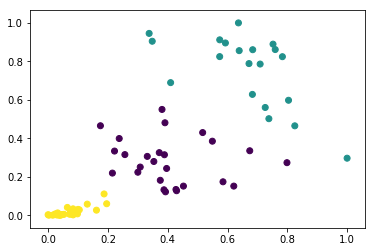

In [186]:
# declare and fit model
km = KMeans(n_clusters = 3).fit(df_cluster.values)

# extract cluster assignments for data points
km_labels = km.labels_
km_cluster_centers = km.cluster_centers_

# Plot the solution.
plt.scatter(df_cluster.values[:, 0], df_cluster.values[:, 1], c = km_labels)
plt.show()

In [187]:
# check the predictions for KMeans
km_pred = km.fit_predict(df_cluster.values)

print('Check the prediction for KMeans:')
print(pd.crosstab(km_labels, km_pred))

Check the prediction for KMeans:
col_0   0   1   2
row_0            
0       0   0  26
1       0  20   0
2      29   0   0


Number of Clusters: 2


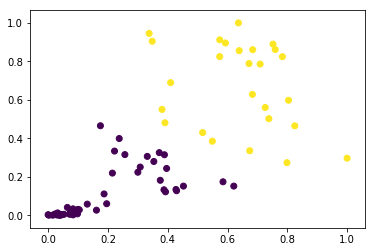

In [156]:
#set bandwidth
bandwidth = estimate_bandwidth(df_cluster.values, quantile = 0.45)       # quantile = 0.5 has 4 clusters

# declare and fit model
ms = MeanShift(bandwidth = bandwidth, bin_seeding = True).fit(df_cluster.values)

# extract cluster assignments for data points
ms_labels = ms.labels_
ms_cluster_centers = ms.cluster_centers_

# count number of clusters
n_clusters = len(np.unique(ms_labels))
print('Number of Clusters: {}'.format(n_clusters))

# Plot the solution.
plt.scatter(df_cluster.values[:, 0], df_cluster.values[:, 1], c = ms_labels)
plt.show()

In [157]:
# check the predictions
ms_pred = ms.fit_predict(df_cluster.values)

print('Check the prediction for Mean-Shift:')
print(pd.crosstab(ms_labels, ms_pred))

Check the prediction for Mean-Shift:
col_0   0   1
row_0        
0      49   0
1       0  26


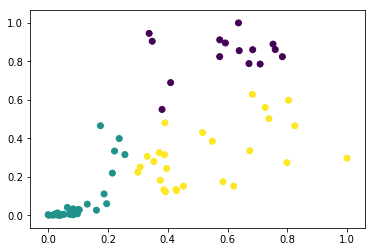

In [158]:
# set number of clusters to 3
n_clusters = 3

# declare and fit the model.
sc = SpectralClustering(n_clusters = n_clusters).fit(df_cluster.values)

# extract cluster assignments for data points
sc_labels = sc.labels_

#Graph results.
plt.scatter(df_cluster.values[:, 0], df_cluster.values[:, 1], c = sc_labels)
plt.show()

In [159]:
# predicted clusters.
sc_pred = sc.fit_predict(df_cluster.values)

print('Check the prediction for Spectral Cluster:')
print(pd.crosstab(sc_labels, sc_pred))

Check the prediction for Spectral Cluster:
col_0   0   1   2
row_0            
0       0   0  15
1       0  34   0
2      26   0   0


In [160]:
# declare and fit model
af = AffinityPropagation().fit(df_cluster.values)

# the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
af_labels = af.labels_

print('Estimated number of clusters: {}'.format(n_clusters_))

Estimated number of clusters: 6


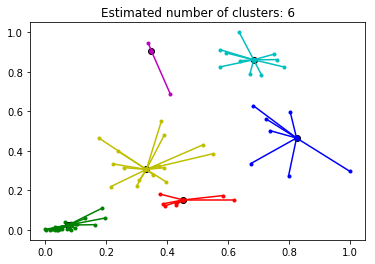

In [161]:
# cycle through each cluster and graph them with a center point for the
# exemplar and lines from the exemplar to each data point in the cluster.
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = af_labels == k
    cluster_center = df_cluster.values[cluster_centers_indices[k]]
    plt.plot(df_cluster.values[class_members, 0], df_cluster.values[class_members, 1], col + '.')
    plt.plot(cluster_center[0],
             cluster_center[1],
             'o',
             markerfacecolor=col,
             markeredgecolor='k')
    for x in df_cluster.values[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: {}'.format(n_clusters_))
plt.show()

In [162]:
# predicted clusters.
af_pred = af.fit_predict(df_cluster.values)

print('Check the prediction for Affinity Propagation:')
print(pd.crosstab(af_labels, af_pred))

Check the prediction for Affinity Propagation:
col_0  0   1  2   3  4   5
row_0                     
0      8   0  0   0  0   0
1      0  29  0   0  0   0
2      0   0  8   0  0   0
3      0   0  0  11  0   0
4      0   0  0   0  3   0
5      0   0  0   0  0  16


##### decided to use KMeans
    I chose KMeans because 
        => mean-shift is not consistently 3 clusters 
        => The distribution of mean-shift and spectral cluster is not what I want
        => affinity propagation has too many clusters

#### --tfidf

In [163]:
# create a function to divide the paragraphs into individuals rows
def divide_paragraph(dat):
    df = pd.DataFrame()
    
    for i, v in enumerate(dat['paragraph']):
        
        # create a temporary dataframe to store each row's paragraph
        df_temp = pd.DataFrame({'paragraph': v})
        df_temp['text_len'] = pd.Series([dat['text_len'][i]] * df_temp.shape[0])
        df_temp['para_len'] = pd.Series([dat['para_len'][i]] * df_temp.shape[0])
        df_temp['category'] = pd.Series([dat['category'][i]] * df_temp.shape[0])
        df_temp['labels'] = pd.Series([dat['labels'][i]] * df_temp.shape[0])
        
        df = pd.concat([df, df_temp])
        
    #reset index
    df.reset_index(drop = ['index'], inplace = True)
        
    return(df)

In [164]:
# create a function for tf-idf  
def tfidf(dat):
    vectorizer = TfidfVectorizer(max_df = 0.5, # drop words that occur in more than half the paragraphs
                                 min_df = 50, # only use words that appear min_df times
                                 stop_words = 'english', 
                                 lowercase = True, #convert everything to lower case 
                                 use_idf = True, #we definitely want to use inverse document frequencies in our weighting
                                 norm = u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                                 smooth_idf = True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                                )


    #Applying the vectorizer
    para_tfidf = vectorizer.fit_transform(dat['paragraph'])
    
    return(para_tfidf)

In [188]:
# labels from K-Means
df_train['labels'] = km_labels

# call functions to get tf-idf vectors
para_train = divide_paragraph(df_train)
train_tfidf = tfidf(para_train)

# create a tf-idf df
train_tfidf = pd.DataFrame(train_tfidf.toarray())

# add features from df_train to tf-idf dataframe
train_tfidf['text_len'] = para_train['text_len']
train_tfidf['para_len'] = para_train['para_len']
train_tfidf['category'] = para_train['category']
train_tfidf['labels'] = para_train['labels']

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy [ipykernel_launcher.py:2]


#### Prepare to Model for tf-idf

In [189]:
# split tf-idf vectorizers into training/test sets
Y = train_tfidf['category']
X = np.array(train_tfidf.drop(['category'], 1))

In [193]:
# SVD data reducer, aim to have around 80% variance explained
svd = TruncatedSVD(500)      
lsa = make_pipeline(svd, Normalizer(copy=False))

# run SVD on the training data, then project the training data.
X_lsa = lsa.fit_transform(X)
Y_lsa = Y

variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:", total_variance * 100)

Percent variance captured by all components: 59.7874105131


    Note: add number of features SVD produce will cause the program to be slower

##### Random Forest

In [194]:
# tf-idf 
rfc = ensemble.RandomForestClassifier()
train = rfc.fit(X_lsa, Y_lsa)

print('Training set score:', rfc.score(X_lsa, Y_lsa))

Training set score: 0.996625042187


##### Logistic Regression

In [195]:
# tf-idf 
lr = LogisticRegression()
train = lr.fit(X_lsa, Y_lsa)

print('Training set score:', lr.score(X_lsa, Y_lsa))

Training set score: 0.880064657087


##### Gradient Boost   (takes too long)

In [196]:
# tf-idf 
clf = ensemble.GradientBoostingClassifier()
train = clf.fit(X_lsa, Y_lsa)

print('Training set score:', clf.score(X_lsa, Y_lsa))

Training set score: 0.971081940423


### Test Holdout Group

In [197]:
# extract text len and para len for cluster
# reset the index for df_test
df_test.reset_index(drop = ['index'], inplace = True)
df_cluster = df_test.loc[:, df_test.columns.isin(['text_len', 'para_len'])]

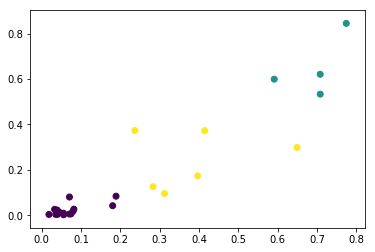

In [198]:
# declare and fit model
km = KMeans(n_clusters = 3).fit(df_cluster.values)

# extract cluster assignments for data points
km_labels = km.labels_
km_cluster_centers = km.cluster_centers_

# Plot the solution.
plt.scatter(df_cluster.values[:, 0], df_cluster.values[:, 1], c = km_labels)
plt.show()

In [199]:
# check the predictions for KMeans
km_pred = km.fit_predict(df_cluster.values)

print('Check the prediction for KMeans:')
print(pd.crosstab(km_labels, km_pred))

Check the prediction for KMeans:
col_0   0  1  2
row_0          
0      15  0  0
1       0  4  0
2       0  1  5


#### tf-idf for holdout group

In [200]:
# create a feature for labels
df_test['labels'] = km_labels

# call functions to get tf-idf vectors
para_test = divide_paragraph(df_test)
test_tfidf = tfidf(para_test)

# create a tf-idf df
test_tfidf = pd.DataFrame(test_tfidf.toarray())

# add features from df_train to tf-idf dataframe
test_tfidf['text_len'] = para_test['text_len']
test_tfidf['para_len'] = para_test['para_len']
test_tfidf['category'] = para_test['category']
test_tfidf['labels'] = para_test['labels']

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy [ipykernel_launcher.py:2]


#### Prepare to Model Holdout Groups

In [201]:
# split tf-idf vectorizers into training/test sets
Y = test_tfidf['category']
X = np.array(test_tfidf.drop(['category'], 1))

In [202]:
# run SVD on the test data, then project the training data.
X_lsa = lsa.fit_transform(X)
Y_lsa = Y

variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:", total_variance * 100)

Percent variance captured by all components: 85.9787377865


##### Random Forest

In [203]:
# tf-idf for holdout group
print('Holdout test score:', rfc.score(X_lsa, Y_lsa))

Holdout test score: 0.606990543297


##### Logistic Regression

In [204]:
# tf-idf for holdout group
print('Holdout test  score:', lr.score(X_lsa, Y_lsa))

Holdout test  score: 0.472649731133


##### Gradient Boost

In [205]:
# tf-idf for holdout group
print('Holdout test score:', clf.score(X_lsa, Y_lsa))

Holdout test score: 0.638049323197


### Cross Validate using all_sample data

In [206]:
# extract text len and para len for cluster
# reset the index for df_test
all_sample.reset_index(drop = ['index'], inplace = True)
df_cluster = all_sample.loc[:, all_sample.columns.isin(['text_len', 'para_len'])]

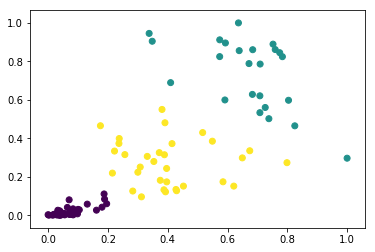

In [207]:
# declare and fit model
km = KMeans(n_clusters = 3).fit(df_cluster.values)

# extract cluster assignments for data points
km_labels = km.labels_
km_cluster_centers = km.cluster_centers_

# Plot the solution.
plt.scatter(df_cluster.values[:, 0], df_cluster.values[:, 1], c = km_labels)
plt.show()

In [208]:
# check the predictions for KMeans
km_pred = km.fit_predict(df_cluster.values)

print('Check the prediction for KMeans:')
print(pd.crosstab(km_labels, km_pred))

Check the prediction for KMeans:
col_0   0   1   2
row_0            
0      44   0   0
1       0   0  24
2       0  32   0


#### tf-idf for holdout group

In [209]:
# create a feature for labels
all_sample['labels'] = km_labels

# call functions to get tf-idf vectors
all_sample_para = divide_paragraph(all_sample)
all_sample_tfidf = tfidf(all_sample_para)

# create a tf-idf df
all_sample_tfidf = pd.DataFrame(all_sample_tfidf.toarray())

# add features from df_train to tf-idf dataframe
all_sample_tfidf['text_len'] = all_sample_para['text_len']
all_sample_tfidf['para_len'] = all_sample_para['para_len']
all_sample_tfidf['category'] = all_sample_para['category']
all_sample_tfidf['labels'] = all_sample_para['labels']

#### Prepare to Model Holdout Groups

In [210]:
# split tf-idf vectorizers into training/test sets
Y = all_sample_tfidf['category']
X = np.array(all_sample_tfidf.drop(['category'], 1))

In [211]:
# run SVD on the test data, then project the training data.
X_lsa = lsa.fit_transform(X)
Y_lsa = Y

variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:", total_variance * 100)

Percent variance captured by all components: 58.2641410505


##### Random Forest

In [212]:
# tf-idf for holdout group
print('Holdout test score:\n', cross_val_score(rfc, X_lsa, Y_lsa, cv = 5))

Holdout test score
: [ 0.71441347  0.76671387  0.72510435  0.71601073  0.75745379]


##### Logistic Regression

In [213]:
# tf-idf for holdout group
print('Holdout test  score:\n', cross_val_score(lr, X_lsa, Y_lsa, cv = 5))

Holdout test  score
: [ 0.70353257  0.86710889  0.75268336  0.85360763  0.79248658]


##### Gradient Boost

In [214]:
# tf-idf for holdout group
print('Holdout test score:\n', cross_val_score(clf, X_lsa, Y_lsa, cv = 5))

Holdout test score
: [ 0.49254732  0.77848998  0.85554562  0.62477639  0.71847048]
